In [82]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
from modules import *
from sim import *
from read_ramses import *


In [542]:
# choose simulation
sim_round = 9
sim_name = "bturbfunc"
sim_dir = move_to_sim_dir(sim_round, sim_name)
sim_latex = sim_name_to_latex[sim_name]
print()

dump = get_dump(a_exp=0.1)
info = get_info(dump)

print("Dump: %d" % dump)
print("a_exp: %.3g" % info.a_exp)
print("Maximum AMR level: %d" % info.amr_level_max)


Moving to directory '/home/za9132/scratch/romain/round9/bturbfunc'.

Dump: 46
a_exp: 0.0991
Maximum AMR level: 13


In [543]:
starbirth_cat = SimpleNamespace(**np.load("starbirth.npz"))
# stardeath_cat = SimpleNamespace(**np.load("stardeath.npz"))


Text(0.1, 0.9, '$t = 531~{\\rm Myr}$')

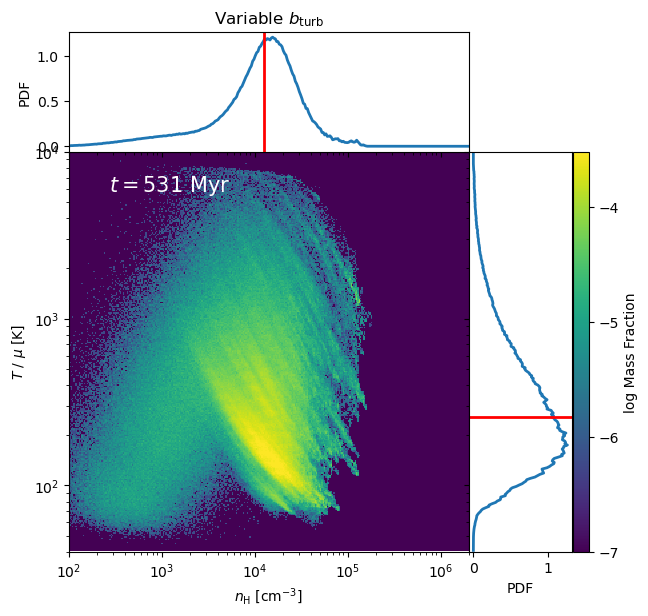

In [544]:
nbins = 300
n_H_extrema = (1e2, 2e6)
temp_extrema = (4e1, 1e4)
mass_frac_extrema = (1e-7, 3e-4)

star_cat = starbirth_cat
time = min(600 * const.Myr, np.max(star_cat.time))
cond = star_cat.time <= time

fig = plt.figure(figsize=(4, 4))
ax1 = fig.add_axes([0, 0, 1, 1])

n_H = const.X_cosmo * star_cat.density / const.m_H
temp = star_cat.temperature

n_H_2d, temperature_2d, mass_2d = calc_phase(n_H[cond], temp[cond], n_H_extrema, temp_extrema, nbins=nbins, weight=star_cat.mass[cond])
mass_frac_2d = mass_2d / np.sum(star_cat.mass)
im = ax1.pcolormesh(n_H_2d, temperature_2d, np.log10(mass_frac_2d + epsilon), vmin=np.log10(mass_frac_extrema[0]), vmax=np.log10(mass_frac_extrema[1]))

ax1.set_xlabel(r"$n_{\rm H}$ [${\rm cm^{-3}}$]")
ax1.set_ylabel(r"$T~/~\mu$ [K]")
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(*n_H_extrema)
ax1.set_ylim(*temp_extrema)

ax2 = fig.add_axes([0, 1, 1, 0.3], sharex=ax1)
plt.setp(ax2.get_xticklabels(), visible=False)
plot_pdf(n_H[cond], ax=ax2, extrema=n_H_extrema, weights=star_cat.mass[cond], do_log=True, do_axes_labels=False, nbins=nbins, show_median=True)
ax2.set_ylabel("PDF")

ax3 = fig.add_axes([1, 0, 0.3, 1], sharey=ax1)
plt.setp(ax3.get_yticklabels(), visible=False);
plot_pdf(temp[cond], ax=ax3, extrema=temp_extrema, weights=star_cat.mass[cond], do_log=True, do_axes_labels=False, nbins=nbins, flip_axes=True, show_median=True)
ax3.set_xlabel("PDF")

cbar_ticks = np.arange(np.log10(mass_frac_extrema[0]), np.log10(mass_frac_extrema[1])+1)
divider = make_axes_locatable(ax3)
cax = divider.append_axes("right", size="15%", pad=0.01)
plt.colorbar(im, ax=ax1, cax=cax, ticks=cbar_ticks, label=r"log Mass Fraction")

ax2.set_title(sim_latex)

ax1.annotate(r'$t = %.3g~{\rm Myr}$' % (time / const.Myr), (0.1, 0.9), xycoords='axes fraction', color='white', fontsize=15)

# save_fig("starbirth-bturb0p3")


Text(0.5, 1.0, 'Variable $b_{\\rm turb}$')

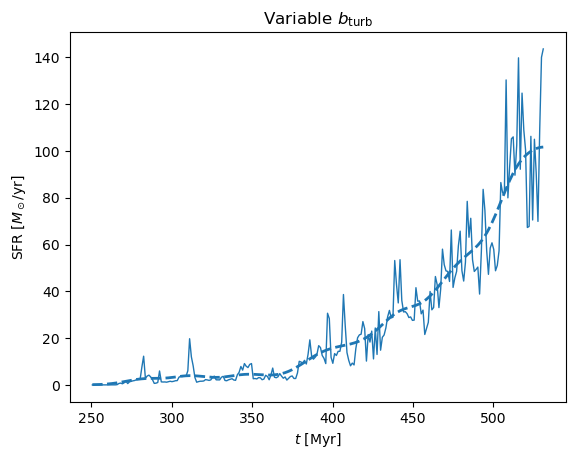

In [545]:
nbins = 256
filter_sigma = 10 * const.Myr

counts, bins = np.histogram(starbirth_cat.time, bins=nbins, weights=starbirth_cat.mass)

star_birthtime_1d = bins[:-1] + np.diff(bins)[0]
star_mass_1d = counts
SFR_mass_1d = star_mass_1d / np.diff(bins)[0]

filter_sigma_idx = filter_sigma / np.diff(star_birthtime_1d)[0]
SFR_mass_1d_smoothed = gaussian_filter(SFR_mass_1d, sigma=filter_sigma_idx)

plt.plot(star_birthtime_1d / const.Myr, SFR_mass_1d / const.M_sol * const.yr, lw=1, alpha=1., label=sim_latex, color='C0')
plt.plot(star_birthtime_1d / const.Myr, SFR_mass_1d_smoothed / const.M_sol * const.yr, lw=2, alpha=1., label=sim_latex, color='C0', linestyle='--')

plt.ylabel(r"SFR [$M_\odot / {\rm yr}$]")
plt.xlabel(r"$t$ [Myr]")

plt.title(sim_latex)

# save_fig("SFR-dxmin")


Text(0.5, 1.0, 'Variable $b_{\\rm turb}$')

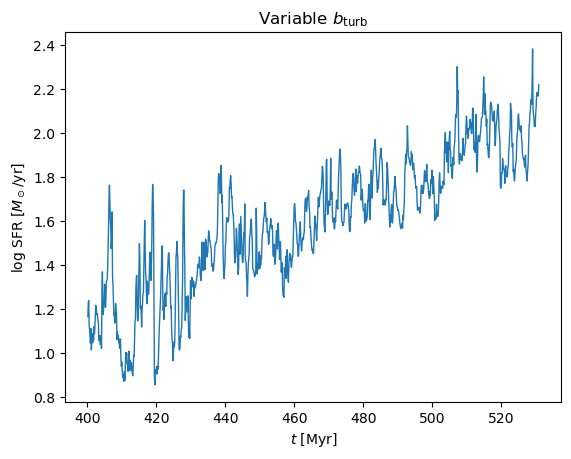

In [561]:
nbins = 1024
time = 400 * const.Myr
cond = starbirth_cat.time > time

star_num, bins = np.histogram(starbirth_cat.time[cond], bins=nbins)
star_mass, bins = np.histogram(starbirth_cat.time[cond], bins=nbins, weights=starbirth_cat.mass[cond])

star_birthtime = bins[:-1] + np.diff(bins)[0]
SFR = star_mass / np.diff(bins)[0]
log_SFR = np.log10(SFR)

shot_noise = np.sqrt(star_num) * star_mass / star_num / np.diff(bins)[0]
log_shot_noise = shot_noise / SFR / np.log(10)

plt.plot(star_birthtime / const.Myr, log_SFR - np.log10(const.M_sol / const.yr), lw=1, label=sim_latex, color='C0')

plt.ylabel(r"log SFR [$M_\odot / {\rm yr}$]")
plt.xlabel(r"$t$ [Myr]")

plt.title(sim_latex)

# save_fig("SFR-dxmin")


### PDF

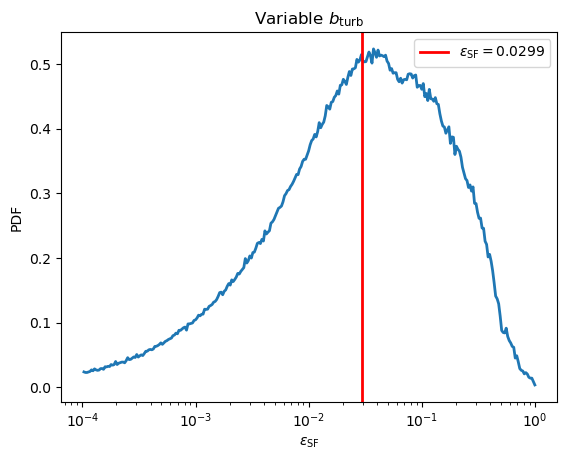

In [336]:
cond = starbirth_cat.time < 1000 * const.Myr

num = 1000
a_exp_list = np.linspace(1e-3, 0.1, num)
time_list = np.array([a_exp_to_proper_time(a_exp_list[i]) for i in range(len(a_exp_list))])
proper_time_to_a_exp_interp = interp1d(time_list, a_exp_list)

a_exp = proper_time_to_a_exp_interp(starbirth_cat.time)
box_size = 100 * const.Mpc
dx = a_exp * box_size / 2**starbirth_cat.level
b_turb = starbirth_cat.b_turb
epsilon_SF = calc_epsilon_SF(starbirth_cat.density, starbirth_cat.energy_turb, starbirth_cat.temperature, dx, b_turb)

plot_pdf(epsilon_SF[cond], extrema=(1e-4, 1e0), weights=starbirth_cat.mass[cond], label=r'$\varepsilon_{\rm SF}$', show_median=True, do_log=True, nbins=300)
plt.title(sim_latex)

eps_median = median_weighted(epsilon_SF[cond], starbirth_cat.mass[cond])
custom_lines = [Line2D([0], [0], color='red', lw=2)]
plt.legend(custom_lines, [r'$\varepsilon_{\rm SF} = %.3g$' % eps_median])

# save_fig('SFEpdf_bturbfunc_highres')


In [352]:
eps_avg = median_weighted(epsilon_SF, starbirth_cat.mass)
rho_avg = median_weighted(starbirth_cat.density, weights=starbirth_cat.mass)
t_ff_avg = np.sqrt(3 * np.pi / (32 * const.G * rho))
dx_avg = median_weighted(dx, starbirth_cat.mass)
dt = info.time_unit * 5e-6

dV_avg = dx_avg**3
rhodot_star_avg = rho_avg * eps_avg / t_ff_avg
Mdot_star_avg = rhodot_star_avg * dV_avg

Mdot_star_avg * dt / const.M_sol


14.551983082153038

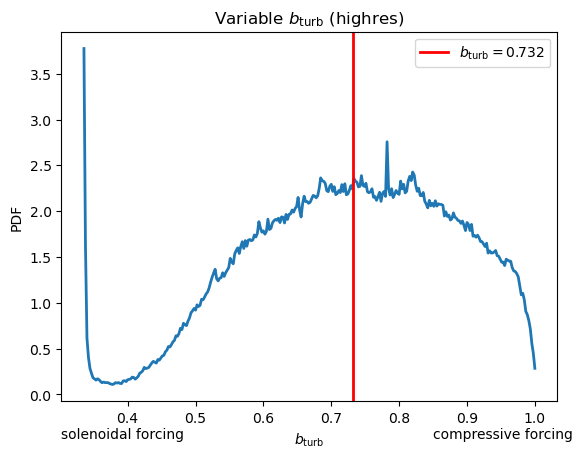

In [75]:
cond = starbirth_cat.time < 600 * const.Myr
plot_pdf(starbirth_cat.b_turb[cond], extrema=(1/3, 1.0), weights=starbirth_cat.mass[cond], label=r'$b_{\rm turb}$', show_median=True, nbins=300, do_log=False)
plt.title(sim_latex)
plt.annotate('solenoidal forcing', (0, -0.1), xycoords='axes fraction')
plt.annotate('compressive forcing', (0.75, -0.1), xycoords='axes fraction')

b_turb_median = median_weighted(starbirth_cat.b_turb[cond], starbirth_cat.mass[cond])
custom_lines = [Line2D([0], [0], color='red', lw=2)]
plt.legend(custom_lines, [r'$b_{\rm turb} = %.3g$' % b_turb_median])

# save_fig('bturbpdf_highres')


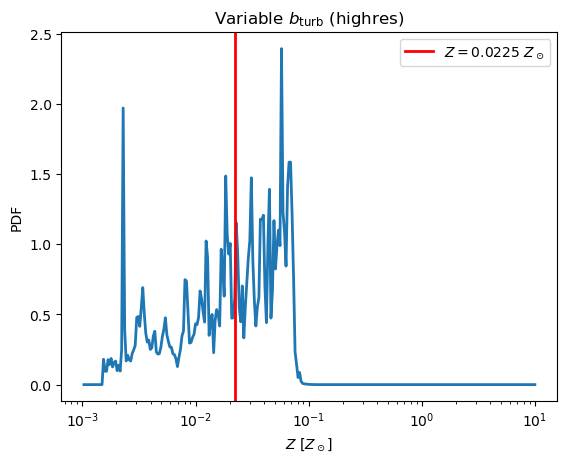

In [64]:
cond = starbirth_cat.time < 1000 * const.Myr
plot_pdf(starbirth_cat.metallicity[cond] / const.Z_sol, extrema=(1e-3, 1e1), weights=starbirth_cat.mass[cond], label=r'$Z$ [$Z_\odot$]', show_median=True, nbins=300)
plt.title(sim_latex)

metallicity_median = median_weighted(starbirth_cat.metallicity[cond] / const.Z_sol, starbirth_cat.mass[cond])
custom_lines = [Line2D([0], [0], color='red', lw=2)]
plt.legend(custom_lines, [r'$Z = %.3g~Z_\odot$' % metallicity_median])


### simulation comparison


Moving to directory '/home/za9132/scratch/romain/round10/bturb0p3_highres'.
Moving to directory '/home/za9132/scratch/romain/round10/bturb1p0_highres'.
Moving to directory '/home/za9132/scratch/romain/round10/bturbfunc_highres'.
Saved figure as 'Zpdf-comp-r10-011720240947.png'


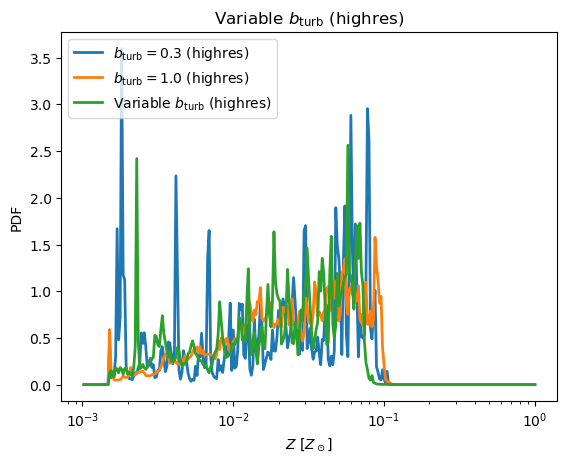

In [80]:
sim_round = 10
list_of_sim_name = ["bturb0p3_highres", "bturb1p0_highres", "bturbfunc_highres"]
nbins = 300
custom_lines, custom_labels = [], []

for i, sim_name in enumerate(list_of_sim_name):

    sim_dir = move_to_sim_dir(sim_round, sim_name)
    sim_latex = sim_name_to_latex[sim_name]
    
    starbirth_cat = SimpleNamespace(**np.load("starbirth.npz"))
    
    plot_pdf(starbirth_cat.metallicity / const.Z_sol, extrema=(1e-3, 1e0), weights=starbirth_cat.mass, label=r'$Z$ [$Z_\odot$]', show_median=False, nbins=300)
    plt.title(sim_latex)

    custom_lines.append(Line2D([0], [0], color='C%d' % i, lw=2))
    custom_labels.append(sim_latex)

plt.legend(custom_lines, custom_labels)
save_fig("Zpdf-comp-r10")


Moving to directory '/home/za9132/scratch/romain/round9/bturb0p3'.
Moving to directory '/home/za9132/scratch/romain/round9/bturb1p0'.
Moving to directory '/home/za9132/scratch/romain/round9/bturbfunc'.
Moving to directory '/home/za9132/scratch/romain/round9/fastfeedback'.


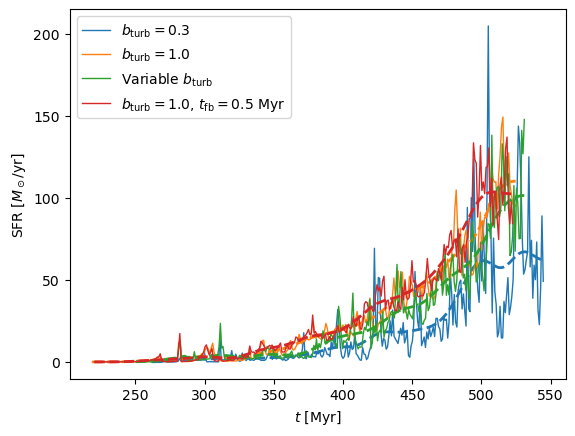

In [115]:
list_of_sim_round = [9]
list_of_sim_name = None
nbins = 300
filter_sigma = 10 * const.Myr

for sim_round in list_of_sim_round:
    
    round_dir = os.path.join(sim_base_dir, "round%d" % sim_round)
    if list_of_sim_name == None: 
        list_of_sim_name_round = sorted(os.listdir(round_dir))
    else:
        list_of_sim_name_round = list_of_sim_name

    for i, sim_name in enumerate(list_of_sim_name_round):

        sim_dir = move_to_sim_dir(sim_round, sim_name)
        sim_latex = sim_name_to_latex[sim_name]

        starbirth_cat = SimpleNamespace(**np.load("starbirth.npz"))

        counts, bins = np.histogram(starbirth_cat.time, bins=nbins, weights=starbirth_cat.mass)

        star_birthtime_1d = bins[:-1] + np.diff(bins)[0]
        star_mass_1d = counts
        SFR_mass_1d = star_mass_1d / np.diff(bins)[0]

        filter_sigma_idx = filter_sigma / np.diff(star_birthtime_1d)[0]
        SFR_mass_1d_smoothed = gaussian_filter(SFR_mass_1d, sigma=filter_sigma_idx)

        plt.plot(star_birthtime_1d / const.Myr, SFR_mass_1d / const.M_sol * const.yr, lw=1, alpha=1., label=sim_latex, color='C%d' % i)
        plt.plot(star_birthtime_1d / const.Myr, SFR_mass_1d_smoothed / const.M_sol * const.yr, lw=2, alpha=1., color='C%d' % i, linestyle='--')

plt.ylabel(r"SFR [$M_\odot / {\rm yr}$]")
plt.xlabel(r"$t$ [Myr]")
plt.legend()
    
# save_fig("SFR-comp-r10")


Moving to directory '/home/za9132/scratch/romain/round9/bturb1p0'.


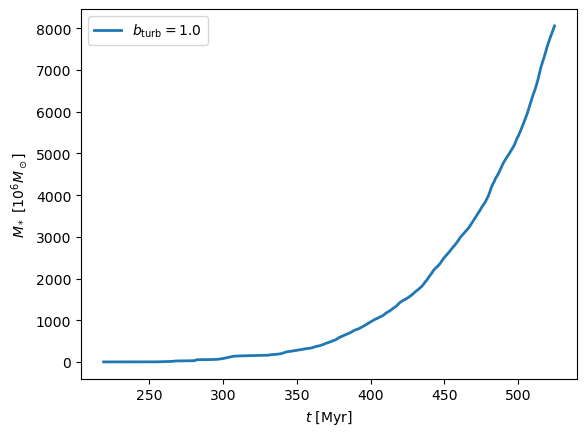

In [11]:
list_of_sim_round = [9]
list_of_sim_name = ["bturb1p0"]
nbins = 300
filter_sigma = 10 * const.Myr

for sim_round in list_of_sim_round:
    
    round_dir = os.path.join(sim_base_dir, "round%d" % sim_round)
    if list_of_sim_name == None: 
        list_of_sim_name_round = sorted(os.listdir(round_dir))
    else:
        list_of_sim_name_round = list_of_sim_name

    for i, sim_name in enumerate(list_of_sim_name_round):

        sim_dir = move_to_sim_dir(sim_round, sim_name)
        sim_latex = sim_name_to_latex[sim_name]

        starbirth_cat = SimpleNamespace(**np.load("starbirth.npz"))

        counts, bins = np.histogram(starbirth_cat.time, bins=nbins, weights=starbirth_cat.mass)

        star_birthtime_1d = bins[:-1] + np.diff(bins)[0]
        star_mass_1d = counts
        star_mass_cum = np.cumsum(star_mass_1d)

        filter_sigma_idx = filter_sigma / np.diff(star_birthtime_1d)[0]
        plt.plot(star_birthtime_1d / const.Myr, star_mass_cum / const.M_sol / 1e6, lw=2, alpha=1., label=sim_latex)

plt.ylabel(r"$M_*$ [$10^6 M_\odot$]")
plt.xlabel(r"$t$ [Myr]")
# plt.yscale('log')
plt.legend()
    
# save_fig("starmass-comp-r910")


Moving to directory '/home/za9132/scratch/romain/round9/bturb0p3'.
Moving to directory '/home/za9132/scratch/romain/round9/bturbfunc'.


/tmp/ipykernel_572116/607393160.py:32: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1 / freq / const.Myr, psd / const.Myr, label=sim_latex, lw=2)


Moving to directory '/home/za9132/scratch/romain/round9/bturb1p0'.
Moving to directory '/home/za9132/scratch/romain/round9/fastfeedback'.


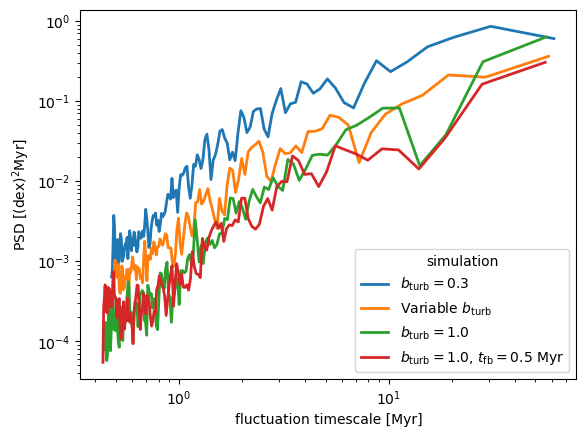

In [572]:
list_of_sim_round = [9]
list_of_sim_name = ["bturb0p3", "bturbfunc", "bturb1p0", "fastfeedback"]

nbins = 1024
time = 300 * const.Myr

for sim_round in list_of_sim_round:
    
    round_dir = os.path.join(sim_base_dir, "round%d" % sim_round)
    if list_of_sim_name == None: 
        list_of_sim_name_round = sorted(os.listdir(round_dir))
    else:
        list_of_sim_name_round = list_of_sim_name

    for i, sim_name in enumerate(list_of_sim_name_round):

        sim_dir = move_to_sim_dir(sim_round, sim_name)
        sim_latex = sim_name_to_latex[sim_name]

        starbirth_cat = SimpleNamespace(**np.load("starbirth.npz"))
        cond = starbirth_cat.time > time
        
        star_mass, bins = np.histogram(starbirth_cat.time[cond], bins=nbins, weights=starbirth_cat.mass[cond])

        star_birthtime = bins[:-1] + np.diff(bins)[0]
        SFR = star_mass / np.diff(bins)[0]
        log_SFR = np.log10(SFR)

        freq_sample = 1. / np.diff(star_birthtime)[0]
        freq, psd = welch(log_SFR, freq_sample, detrend='linear')

        plt.plot(1 / freq / const.Myr, psd / const.Myr, label=sim_latex, lw=2)
        
plt.xlabel(r'fluctuation timescale [Myr]')
plt.ylabel(r'PSD [${\rm (dex)^2 Myr}$]')
plt.xscale('log')
plt.yscale('log')
plt.legend(title='simulation')
